In [ ]:
# connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import cv2

In [ ]:
train_dir = '/content/drive/MyDrive/AcRecogDataset/AcRecogDataset/train'
test_dir = '/content/drive/MyDrive/AcRecogDataset/AcRecogDataset/test'

In [ ]:
dataset_path_train = os.listdir(train_dir)
dataset_path_test = os.listdir(test_dir)

In [ ]:
label_types = os.listdir(train_dir)

label_types

['BenchPress', 'Biking', 'Basketball']

In [ ]:
# Train Data

rooms_train = []

for item in dataset_path_train:
    # Get all the file names
    all_rooms = os.listdir(train_dir+'/'+item)

    # Add them to the list
    for room in all_rooms:
        rooms_train.append((item, str(train_dir+'/'+item)+'/'+room))

# Build a dataframe
train_df = pd.DataFrame(data=rooms_train, columns=['tag', 'video_name'])

train_df

,tag,video_name
0,BenchPress,/content/drive/MyDrive/AcRecogDataset/AcRecogD...
1,BenchPress,/content/drive/MyDrive/AcRecogDataset/AcRecogD...
2,BenchPress,/content/drive/MyDrive/AcRecogDataset/AcRecogD...
3,BenchPress,/content/drive/MyDrive/AcRecogDataset/AcRecogD...
4,BenchPress,/content/drive/MyDrive/AcRecogDataset/AcRecogD...
...,...,...
300,Basketball,/content/drive/MyDrive/AcRecogDataset/AcRecogD...
301,Basketball,/content/drive/MyDrive/AcRecogDataset/AcRecogD...
302,Basketball,/content/drive/MyDrive/AcRecogDataset/AcRecogD...
303,Basketball,/content/drive/MyDrive/AcRecogDataset/AcRecogD...


In [ ]:
# Test Data

rooms_test = []

for item in dataset_path_test:
    # Get all the file names
    all_rooms = os.listdir(test_dir+'/'+item)

    # Add them to the list
    for room in all_rooms:
        rooms_test.append((item, str(test_dir+'/'+item)+'/'+room))

# Build a dataframe
test_df = pd.DataFrame(data=rooms_test, columns=['tag', 'video_name'])

test_df

,tag,video_name
0,Basketball,/content/drive/MyDrive/AcRecogDataset/AcRecogD...
1,Basketball,/content/drive/MyDrive/AcRecogDataset/AcRecogD...
2,Basketball,/content/drive/MyDrive/AcRecogDataset/AcRecogD...
3,Basketball,/content/drive/MyDrive/AcRecogDataset/AcRecogD...
4,Basketball,/content/drive/MyDrive/AcRecogDataset/AcRecogD...
5,Basketball,/content/drive/MyDrive/AcRecogDataset/AcRecogD...
6,Basketball,/content/drive/MyDrive/AcRecogDataset/AcRecogD...
7,Basketball,/content/drive/MyDrive/AcRecogDataset/AcRecogD...
8,Basketball,/content/drive/MyDrive/AcRecogDataset/AcRecogD...
9,BenchPress,/content/drive/MyDrive/AcRecogDataset/AcRecogD...


In [ ]:
df_train = train_df.loc[:, ['video_name', 'tag']]
df_train.to_csv('/content/drive/MyDrive/AcRecogDataset/AcRecogDataset/train.csv')

df_test = test_df.loc[:, ['video_name', 'tag']]
df_test.to_csv('/content/drive/MyDrive/AcRecogDataset/AcRecogDataset/test.csv')

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/AcRecogDataset/AcRecogDataset/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/AcRecogDataset/AcRecogDataset/test.csv')

In [ ]:
IMG_SIZE = 320

def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
label_processor = tf.keras.layers.experimental.preprocessing.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]))

label_processor.get_vocabulary()

['Basketball', 'BenchPress', 'Biking']

In [ ]:
labels = train_df["tag"].values
labels = label_processor(labels[None]).numpy()

labels

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
#Define hyperparameters
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 30 # number of frames 
NUM_FEATURES = 2048 # the number of features to be detected, you can set it as you like


def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()

    ##take all classlabels from train_df column named 'tag' and store in labels
    labels = df["tag"].values

    # convert classlabels to label encoding
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")  # 145,20
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")  # 145,20,2048

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [ ]:
train_data, train_labels = prepare_all_videos(train_df, "train")

train_data, train_labels

((array([[[2.34516084e-01, 5.45570791e-01, 3.56945246e-02, ...,
           7.56596997e-02, 3.85257691e-01, 3.45119119e-01],
          [1.54937446e-01, 4.49824572e-01, 4.41937074e-02, ...,
           1.43554643e-01, 3.39414001e-01, 1.68098658e-01],
          [2.56523967e-01, 5.62874556e-01, 2.08733827e-02, ...,
           4.64639254e-02, 4.59368914e-01, 1.29925951e-01],
          ...,
          [4.24798578e-02, 5.99763513e-01, 3.98409292e-02, ...,
           4.54635844e-02, 5.96088111e-01, 1.60882264e-01],
          [1.26842976e-01, 7.76129305e-01, 6.45169765e-02, ...,
           7.76717290e-02, 5.24482131e-01, 2.05666751e-01],
          [8.13286304e-02, 6.65563941e-01, 9.04743150e-02, ...,
           8.07318985e-02, 4.35355902e-01, 3.04931134e-01]],
  
         [[4.07023460e-01, 2.95245409e-01, 2.03118294e-01, ...,
           3.62877220e-01, 9.80376005e-01, 1.71541929e-01],
          [4.26142573e-01, 3.56949627e-01, 2.49527961e-01, ...,
           3.37457567e-01, 7.45941401e-01, 1.8185

In [ ]:
test_data, test_labels = prepare_all_videos(test_df, "test")

test_data, test_labels

In [ ]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    # it will be very useful for you to visit the website
    
    x = keras.layers.GRU(64, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(64)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

In [23]:
def run_experiment():
    filepath = "/content/drive/MyDrive/AcRecogDataset/AcRecogDataset/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()

    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print('\n')
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


In [24]:
_, sequence_model = run_experiment()

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.9627 - accuracy: 0.5164
Epoch 1: val_loss improved from inf to 0.84828, saving model to /content/drive/MyDrive/AcRecogDataset/AcRecogDataset/video_classifier
8/8 [==============================] - 11s 349ms/step - loss: 0.9627 - accuracy: 0.5164 - val_loss: 0.8483 - val_accuracy: 0.8197
Epoch 2/100
5/8 [=================>............] - ETA: 0s - loss: 0.6382 - accuracy: 0.9187
Epoch 2: val_loss improved from 0.84828 to 0.73332, saving model to /content/drive/MyDrive/AcRecogDataset/AcRecogDataset/video_classifier
8/8 [==============================] - 0s 34ms/step - loss: 0.5674 - accuracy: 0.9180 - val_loss: 0.7333 - val_accuracy: 0.7377
Epoch 3/100
5/8 [=================>............] - ETA: 0s - loss: 0.2265 - accuracy: 0.9750
Epoch 3: val_loss did not improve from 0.73332
8/8 [==============================] - 0s 22ms/step - loss: 0.2083 - accuracy: 0.9713 - val_loss: 0.7458 - val_accuracy: 0.7377
Epoch 4/100
5/8 

Test video path: /content/drive/MyDrive/AcRecogDataset/AcRecogDataset/test/Biking/v_Biking_g25_c02.avi

  Biking: 96.94%
  Basketball:  2.78%
  BenchPress:  0.28%

Test frame shape: (151, 320, 320, 3), video has 151 frames 



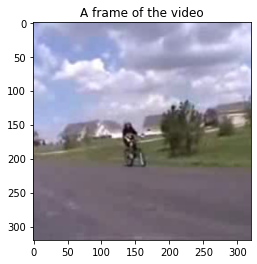

In [36]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)

    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

test_video = np.random.choice(test_df["video_name"].values.tolist()) # we get the information of a video in a random way from the file

print(f"Test video path: {test_video}\n")

test_frames = sequence_prediction(test_video)

print(f'\nTest frame shape: {test_frames.shape}, video has {test_frames.shape[0]} frames \n')

plt.title('A frame of the video')
plt.imshow(test_frames[0], cmap='gray')

In [31]:
# we saved the model we are training in order to use it
sequence_model.save('my_model.h5')